数千，数万人の人々による複雑な問題の答えを一つにまとめよう．それはしばしば一人の専門家の答えより良いことが多い．  
これを**集合知**と言う

アンサンブルはプロジェクトの終わりになってから使うことが多いが，**すでに少数の良い予測器ができているならばそれらを組み合わせればさらに良い予測器になる．**実際に，コンテストの優勝者は複数のアンサンブルメソッドを使っていることが多い（例えばNetflix賞など）

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Voting classifiers

各分類器（ロジスティック回帰分類器，SVM分類器，ランダムフォレスト分類器，その他，，，）がそれぞれ80%くらいの性能を得られたとしよう．  
これらよりも性能の高い分類器を作る非常に単純な方法は，各分類器の予測を集め，多数決で決まったクラスを全体の予測とすることだ．  
この多数決による分類を**ハード投票**という．

驚くことにこの投票分類器は，アンサンブルの中で最良の分類器よりも高い正解率を達成することが多い．  
それどころか，個々の分類器が**弱分類器**（無作為な予測よりわずかに良い程度）でも，**数が十分であり，それぞれが十分に多様ならば，強学習器になる．**

試しに表が51%の確率で出る（弱学習器）コイントスをしてみよう，  
下記例では10シリーズ（10個のコイン）行なっている

In [ ]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

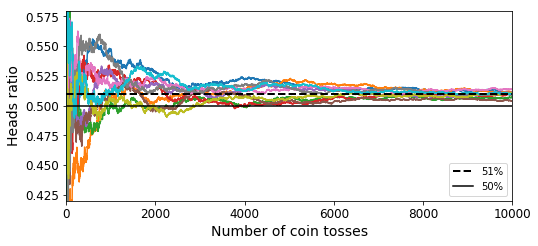

In [4]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

序盤の試行回数こそ多数決で裏と判定してしまうかもしれないが，試行回数を増やせば，多数決で表と判断する（多数決で正解をとる）確率が高まる．  
ちなみに数学的に算出すると，1000回の試行を行えば75%近くの確率で多数決で表となり，10000回で97%を超える．これを**大数の法則**と言う．

言い換えると，どんなに弱学習器でも1000個の分類器でアンサンブルすれば75%の確率で正解を出すことができるということである．  
**ただし，**これが正しいのは，**個々の分類器が完全に独立していて，謝りに相関関係が無い場合だ．**同じデータで訓練すればそのような条件は満たされない．同じタイプの誤判定を犯し，多数決で誤判定を犯すため，アンサンブルの正解率は下がるはずだ．

アンサンブルメソッドは，予測器相互の独立性が高ければ高いほど性能が高くなるので，大きく異なるアルゴリズムを使って訓練すると良い．

## hard and soft voting

ハード投票：各分類器が判定した1or0の結果で多数決をとる  
ソフト投票：各分類器が確率を推計できる（predict_proba()が使える）時に，それぞれの確率の平均をとった上で最も確率の高いものを予測値とする

ソフト投票の方が，自身の高い投票の重みを重視できるため，ハード投票よりも高い性能を示すことが多い．

VotingClassifierのvotingパラメータで簡単に切り替え可能

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier

hard voting

In [ ]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [13]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/Users/yamaji/study/python/py36/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


soft voting

SVCではデフォルトでは確率を推計しない（時間がかかる）ので，パラメータで指定する．

In [14]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


/Users/yamaji/study/python/py36/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ソフト投票の方が性能が高い